In [4]:
import pandas as pd
from seaborn import pairplot
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('data.csv')

data = data.drop(columns=['id', 'genre'])
data.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.0533,0.868,0.407,0.000000,0.119,-14.503,0.4490,127.918,0.593
1,0.0533,0.868,0.407,0.000000,0.119,-14.503,0.4490,127.918,0.593
2,0.1440,0.723,0.740,0.000003,0.212,-5.247,0.0478,98.003,0.286
3,0.1440,0.723,0.740,0.000003,0.212,-5.247,0.0478,98.003,0.286
4,0.1440,0.723,0.740,0.000003,0.212,-5.247,0.0478,98.003,0.286


Cluster Counts:1    1021
4     874
3     782
0     581
2     490
Name: count, dtype: int64


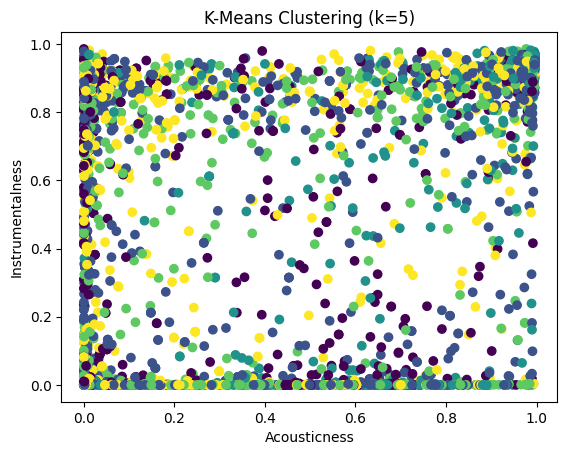

In [5]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=1)
kmeans.fit(data)

# Accessing cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
cluster_counts = pd.Series(labels).value_counts()
print(f"Cluster Counts:{cluster_counts}")
# Plotting the data using two features: "sw" (sepal width) and "sl" (sepal length)
plt.scatter(data["acousticness"], data["instrumentalness"], c=labels, cmap='viridis')
plt.xlabel('Acousticness')
plt.ylabel('Instrumentalness')
plt.title('K-Means Clustering (k=5)')
plt.show()

Cluster Counts:0    1283
1     940
3     532
2     508
4     485
Name: count, dtype: int64


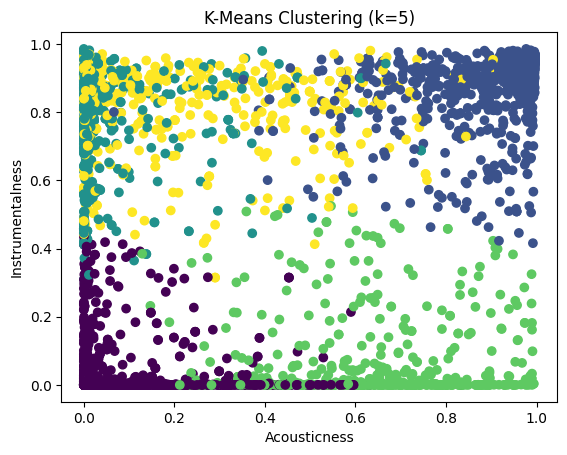

In [6]:
from sklearn.preprocessing import normalize

columns_to_normalize = ['loudness', 'tempo']

data[columns_to_normalize] = normalize(data[columns_to_normalize])

kmeans = KMeans(n_clusters=5)
kmeans.fit(data)

# Accessing cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
cluster_counts = pd.Series(labels).value_counts()
print(f"Cluster Counts:{cluster_counts}")
# Plotting the data using two features: "sw" (sepal width) and "sl" (sepal length)
plt.scatter(data["acousticness"], data["instrumentalness"], c=labels, cmap='viridis')
plt.xlabel('Acousticness')
plt.ylabel('Instrumentalness')
plt.title('K-Means Clustering (k=5)')
plt.show()

Cluster Counts:2    1229
0     878
3     500
1     486
4     467
Name: count, dtype: int64


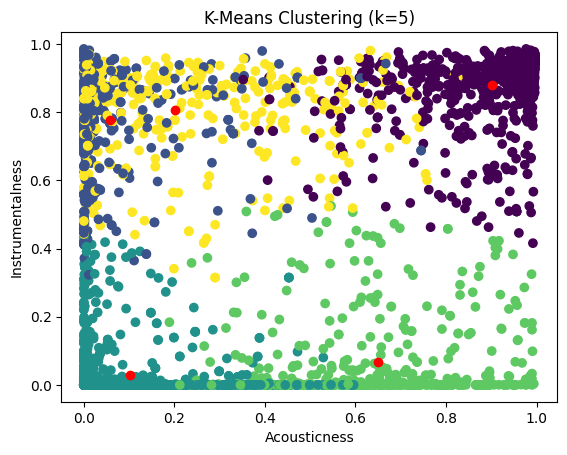

In [57]:
from sklearn.neighbors import LocalOutlierFactor

# Fit Local Outlier Factor (LOF)
# n_neighbors=10: checking the 10 nearest neighbors
# novelty=False: used to fit LOF model on training data
contamination = 0.05

lof = LocalOutlierFactor(n_neighbors=10, contamination=contamination)  #

# Fit and predict outliers (-1 for outlier, 1 for inliers)
data['outlier_lof'] = lof.fit_predict(data)

# Mark the outliers
outliers_lof = data[data['outlier_lof'] == -1]

filtered_data = data[data['outlier_lof'] == 1].copy()

# Fit KMeans to the filtered data (inliers only)
kmeans = KMeans(n_clusters=5)
kmeans.fit(filtered_data)  # Only use relevant features for clustering

# Accessing cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
cluster_counts = pd.Series(labels).value_counts()
print(f"Cluster Counts:{cluster_counts}")
# Plot the filtered data using two features: "sw" (sepal width) and "sl" (sepal length)
plt.scatter(filtered_data["acousticness"], filtered_data["instrumentalness"], c=labels, cmap='viridis')
plt.scatter(centroids[:,0], centroids[:,3], c='r')
plt.xlabel('Acousticness')
plt.ylabel('Instrumentalness')
plt.title('K-Means Clustering (k=5)')
plt.show()

The optimal value of K is 4 with a Davies-Bouldin index of 1.0635656577279449


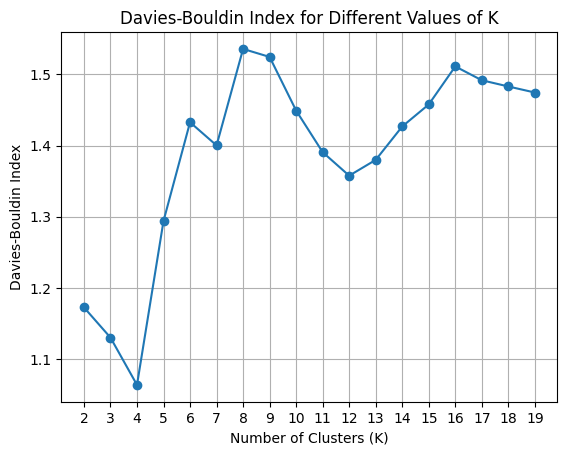

In [12]:
from sklearn.metrics import davies_bouldin_score
k_values = range(2,20)
db_score = []

for k in k_values:
    # Fit KMeans to the filtered data (inliers only)
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(filtered_data)  # Only use relevant features for clustering
    labels = kmeans.labels_
    db_score.append(davies_bouldin_score(filtered_data, labels))

min_db_score = min(db_score)
optimal_k = k_values[db_score.index(min_db_score)]
print(f"The optimal value of K is {optimal_k} with a Davies-Bouldin index of {min_db_score}")

# Plot the Davies-Bouldin index for each K
plt.plot(k_values, db_score, marker='o')
plt.title('Davies-Bouldin Index for Different Values of K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(k_values)
plt.grid()
plt.show()

Cluster Counts: 0    1113
 2     835
-1     830
 1     569
 3     213
Name: count, dtype: int64


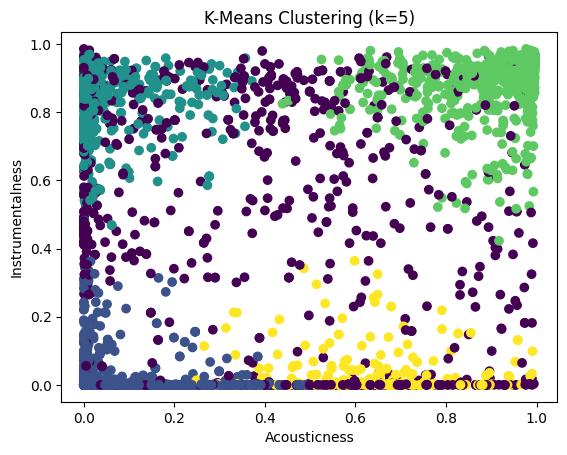

In [37]:
from sklearn.cluster import DBSCAN
import numpy as np

# Assuming filtered_data is your dataset
# DBSCAN with eps=1 and min_samples=5
model = DBSCAN(eps=0.3, min_samples=100).fit(filtered_data)
dbscan_labels = model.labels_
# print(dbscan_labels)

cluster_counts = pd.Series(dbscan_labels).value_counts()
print(f"Cluster Counts:{cluster_counts}")
# Plotting the data using two features: "sw" (sepal width) and "sl" (sepal length)
plt.scatter(filtered_data["acousticness"], filtered_data["instrumentalness"], c=dbscan_labels, cmap='viridis')
plt.xlabel('Acousticness')
plt.ylabel('Instrumentalness')
plt.title('K-Means Clustering (k=5)')
plt.show()


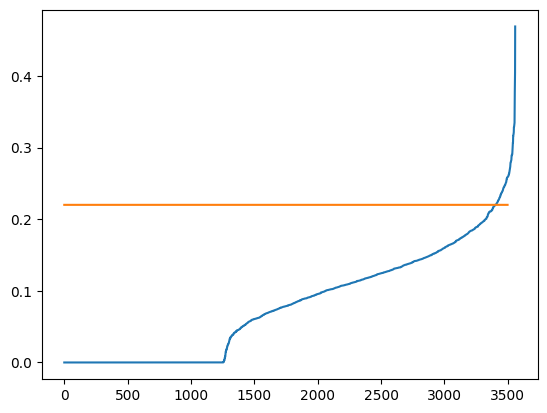

In [29]:
# Plot k-distances
from sklearn.neighbors import NearestNeighbors
def k_distances2(X,n):
    neighbors = NearestNeighbors(n_neighbors=n)
    neighbors_fit = neighbors.fit(X)
    distances, indices = neighbors_fit.kneighbors(X)
    return distances, indices
# TODO: add your parameters here.
# data -- your normalized dataset
# k -- k-th neighbour. By default, k=count(features)+1
distances, indices = k_distances2(filtered_data,5)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.plot(range(3500), [0.22]*3500)
plt.show()


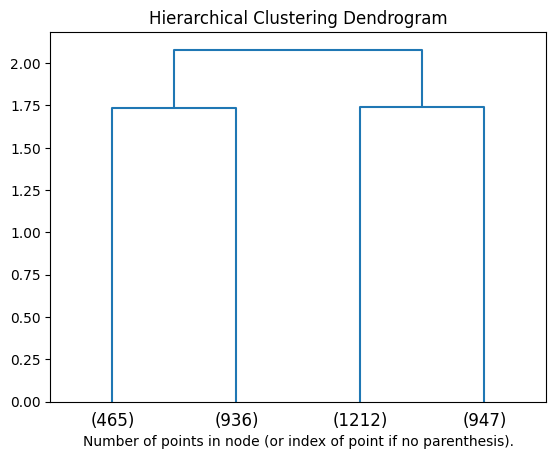

In [43]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering



def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='complete')

model = model.fit(filtered_data)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=1)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Cluster Counts:2    1110
4     835
3     747
1     517
0     351
Name: count, dtype: int64


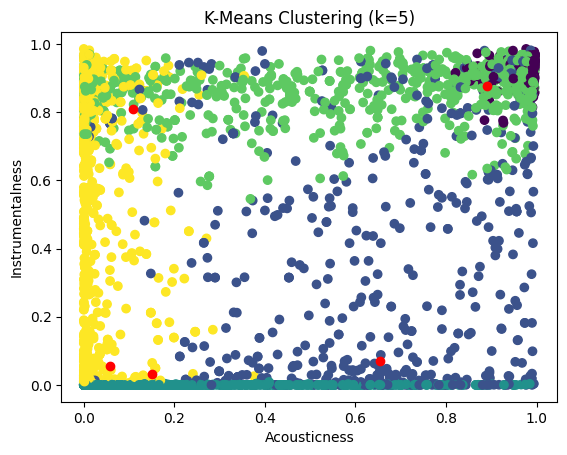

In [51]:
from sklearn.mixture import GaussianMixture

# Fit KMeans to the filtered data (inliers only)
GMM = GaussianMixture(n_components=5, covariance_type='full', random_state=1)
GMM.fit(filtered_data)  # Only use relevant features for clustering

# Accessing cluster labels and centroids
labels = GMM.predict(filtered_data)
centroids = kmeans.cluster_centers_
cluster_counts = pd.Series(labels).value_counts()
print(f"Cluster Counts:{cluster_counts}")
# Plot the filtered data using two features: "sw" (sepal width) and "sl" (sepal length)
plt.scatter(filtered_data["acousticness"], filtered_data["instrumentalness"], c=labels, cmap='viridis')
plt.scatter(centroids[:,0], centroids[:,3], c='r')
plt.xlabel('Acousticness')
plt.ylabel('Instrumentalness')
plt.title('K-Means Clustering (k=5)')
plt.show()